## Youtube Data


In [28]:
! pip install pytube
import pandas as pd
import numpy as np
import cv2
import os
from pytube import YouTube

#paths for training and lables file in dataset

train_text = r'M:\VS_code\flickr\Hashtag generator\sports-1m-dataset\original\train_partition.txt'
labels_text=r'M:\VS_code\flickr\Hashtag generator\sports-1m-dataset\labels.txt'

#creating dataframe with the text data

df = pd.read_csv(train_text, sep='\s+', header=None, names=['URL', 'ID'])
labels = pd.read_csv(labels_text,header=None,names=['Games'])
#print(df[:5])
c= df['URL']
#print(c)
#print(labels.iloc[int(c)])
frames =[df,labels]
#print(len(c))
#print(labels[:3])
#print(len(labels))
combined =pd.concat(frames,ignore_index=True)

#downloading the video from the link 

def download_video(video_link, output_folder='videos'):
    try:
        yt = YouTube(video_link)
        chosen_stream = yt.streams.filter(res="360p", file_extension="mp4").first()
        chosen_stream.download(output_path=output_folder)
        print(f'Video downloaded successfully')
    except Exception as e:
        print(f'Error downloading video: {e}')
        
output_folder = 'videos'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for i in range(1):
    link = df['URL'][i]
    download_video(link)
    
def delete_videos(video_folder='videos'):
    try:
        # List all files in the video folder
        video_files = os.listdir(video_folder)

        # Iterate through the files and delete each one
        for video_file in video_files:
            video_path = os.path.join(video_folder, video_file)
            os.remove(video_path)

        # Remove the video folder itself
        os.rmdir(video_folder)

        print(f'Videos deleted successfully')
    except Exception as e:
        print(f'Error deleting videos: {e}')

Video downloaded successfully


In [30]:
#! python.exe -m pip install --upgrade pip
download_video('https://youtube.com/shorts/NFHanLS9g5k?si=Cajnyu37nDfRuhi3')

Video downloaded successfully


In [4]:
# Extracting frames from the Video and then saving the pictures
def extract_frames(video_path, output_folder='frames', frame_interval=2):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the frames per second (fps) and total number of frames
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the frame interval based on the specified interval
    frame_interval = max(1, int(fps * frame_interval))

    # Loop through the frames and save every nth frame
    for frame_num in range(0, total_frames, frame_interval):
        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

        # Read the frame
        ret, frame = cap.read()

        # Save the frame as an image
        if ret:
            frame_path = os.path.join(output_folder, f'frame_{frame_num}.jpg')
            cv2.imwrite(frame_path, frame)

    # Release the video capture object
    cap.release()

    print(f'Frames extracted successfully. Check the \'{output_folder}\' folder.')
extract_frames('/kaggle/working/videos/How to Swim Perfect Freestyle in 60 Seconds.mp4')

Frames extracted successfully. Check the 'frames' folder.


 ## Training model

In [5]:
import tensorflow as tf
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
warnings.filterwarnings('ignore')


In [7]:
# Path of the images and text file
path=r'M:\VS_code\flickr\Hashtag generator\Images'
#images_path = '/kaggle/input/flickr-image-dataset/'
data = pd.read_csv(r'M:\VS_code\flickr\Hashtag generator\captions.txt')
data.head()
#print(type(data[' caption']))

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [8]:
def read_image(path,img_size=224):
    img =load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img =img/255
    return img

def display_imgs(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20,20))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace=0.7,wspace=0.3)
        image = read_image(f'{path}/{temp_df.image_name[i]}')
        plt.imshow(image)
        plt.title('\n'.join(wrap(temp_df.caption[i],20)))
        plt.axis('off')

In [11]:
def text_processing(data):
    data['caption'] = data['caption'].astype(str)
    data['caption'] = data['caption'].apply(lambda x:x.lower())
    data['caption'] = data['caption'].apply(lambda x:x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x:x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x:" ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = 'startseq '+data['caption']+' endseq'
    
    return data

data_processed = text_processing(data)
print(len(data))

40455


In [12]:
captions =data_processed['caption'].tolist()
captions[0]

'startseq child in pink dress is climbing up set of stairs in an entry way endseq'

In [14]:

# Creating a word tokenizer
tokenizer =Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index)+1

# creating max_length param to gert the padding length
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
#print(images)
n_images =len(images)
split_index = round(0.85*n_images)

# splitting data for training and testing
train_images = images[:split_index]
test_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test =data[data['image'].isin(test_images)]

train.reset_index(inplace =True,drop =True)
test.reset_index(inplace =True,drop =True)
#tokenizer.texts_to_sequences([captions[8]])[0]

In [15]:
model =DenseNet201()
fe = Model(inputs =model.input,outputs =model.layers[-2].output)

In [16]:

def ext_features(images_list,path):
    features = {}
    for image in tqdm(images_list):
        img = read_image(f'{path}/{image}')
        img =np.expand_dims(img,axis=0)
        feature =fe.predict(img,verbose=0)
        features[image] =feature
    return features

In [ ]:
pickle_file = '/kaggle/input/downloaded-data/features (1).pickle'
    
# Check if the pickle file already exists
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        features = pickle.load(f)
else:
    features = ext_features()
    with open(pickle_file, 'wb') as f:
            pickle.dump(features, f)


In [17]:
# Extracting individual features

def ind_features(path,image):
    features ={}
    img =read_image(f'{path}/{image}')
    img =np.expand_dims(img,axis=0)
    feature =fe.predict(img,verbose=0)
    features[image] =feature
    return features

In [18]:
class CustomDataGeneratot(Sequence):
    def __init__(self,df,X_col,y_col,batch_size,directory,tokenizer,vocab_size,max_length,features,shuffle=True):
        self.df=df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df =self.df.sample(frac =1).reset_index(drop=True)
    def __len__(self):
        return self.n//self.batch_size
    def __getitem__(self,index):
        batch =self.df.iloc[index*self.batch_size:(index+1)*self.batch_size,:]
        X1,X2,y =self.__get_data(batch)
        return (X1,X2),y
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


In [19]:
input1 = Input(shape=1920,)
input2 = Input(shape=(max_length,))

img_features = Dense(256,activation='relu')(input1)
img_features_reshaped =Reshape((1,256),input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size,256,mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features =LSTM(256)(merged)

x=Dropout(0.5)(sentence_features)
x=add([x,img_features])
x=Dense(128,activation ='relu')(x)
x=Dropout(0.5)(x)
output =Dense(vocab_size,activation='softmax')(x)
caption_model =Model(inputs=[input1,input2],outputs =output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [20]:
train_generator =CustomDataGeneratot(df=train,X_col='image_name',y_col='caption',batch_size =64,directory=images_path,tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)
validation_generator = CustomDataGeneratot(df=test,X_col='image_name',y_col='caption',batch_size =64,directory=images_path,tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)


NameError: name 'features' is not defined

In [21]:
model_name = 'image_captioning_model.h5'

checkpoint = ModelCheckpoint(model_name,
                            monitor='val_loss',
                            mode='min',
                            save_best_only =True,
                            verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [ ]:
#training = caption_model.fit(train_generator,
 #                           epochs=25,
  #                          validation_data=validation_generator,
#                         callbacks=[checkpoint,learning_rate_reduction])

In [23]:
model_path = 'M:\VS_code\image_captioning_model (2).h5'
loaded_model = tf.keras.models.load_model(model_path)

In [24]:
def retokenizer(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [25]:
def remove_start_end_tokens(sentence):
    start_token = 'startseq'
    end_token = 'endseq'

    # Check if both start and end tokens are present in the sentence
    if start_token in sentence and end_token in sentence:
        # Remove both start and end tokens
        cleaned_sentence = sentence.replace(start_token, '').replace(end_token, '')
        # Remove extra whitespaces
        cleaned_sentence = ' '.join(cleaned_sentence.split())
        return cleaned_sentence
    else:
        # If start or end token is not found, return the original sentence
        return sentence

In [27]:
path ='/kaggle/working/frames'
vid_images = os.listdir(path)
features = ext_features(vid_images,path)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/working/frames'

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = retokenizer(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break

    in_text =remove_start_end_tokens(in_text)
       
    return in_text 

In [ ]:
predicted_dict={}
for index , record in samples.iterrows():
    #print(record)
    img = load_img(os.path.join(path,record['image_name']),target_size =(224,224))
    img =img_to_array(img)
    img =img/255
    caption = predict_caption(loaded_model,record['image_name'],tokenizer,max_length,features)
    predicted_dict[record['image_name']] = caption
    samples.loc[index,'caption'] = caption

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/frames/609681901.jpg'

In [ ]:
gen_captions = {}
for image in vid_images:
    vid_captions = predict_caption(loaded_model,image,tokenizer,max_length,features)
    gen_captions[image] = vid_captions

1/1 [==============================] - 0s 20ms/step


In [ ]:
gen_captions_df = pd.DataFrame(list(gen_captions.items()), columns=['image', 'caption'])
print(gen_captions_df)

             image                                           caption
0   frame_1242.jpg        man in red shirt is jumping into the water
1     frame_46.jpg            man in red shirt is jumping in the air
2    frame_276.jpg       man in blue shirt is jumping into the water
3    frame_782.jpg        man in blue shirt is swimming in the water
4    frame_230.jpg         man in blue shirt is playing in the water
5    frame_828.jpg       man in blue shirt is jumping into the water
6    frame_736.jpg         man in blue shirt is playing in the water
7    frame_138.jpg           man in blue shirt is jumping in the air
8   frame_1104.jpg        man in blue shirt is swimming in the water
9   frame_1288.jpg            man in red shirt is jumping in the air
10   frame_966.jpg         man in blue shirt is jumping on the beach
11  frame_1012.jpg         man in blue shirt is jumping into the air
12  frame_1196.jpg       man in blue shirt is jumping into the water
13   frame_920.jpg         man in 

In [ ]:
def display_imgs(temp_df,path):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20,20))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace=0.7,wspace=0.3)
        image = read_image(f'{path}/{temp_df.image[i]}')
        plt.imshow(image)
        plt.title('\n'.join(wrap(temp_df.caption[i],20)))
        plt.axis('off')

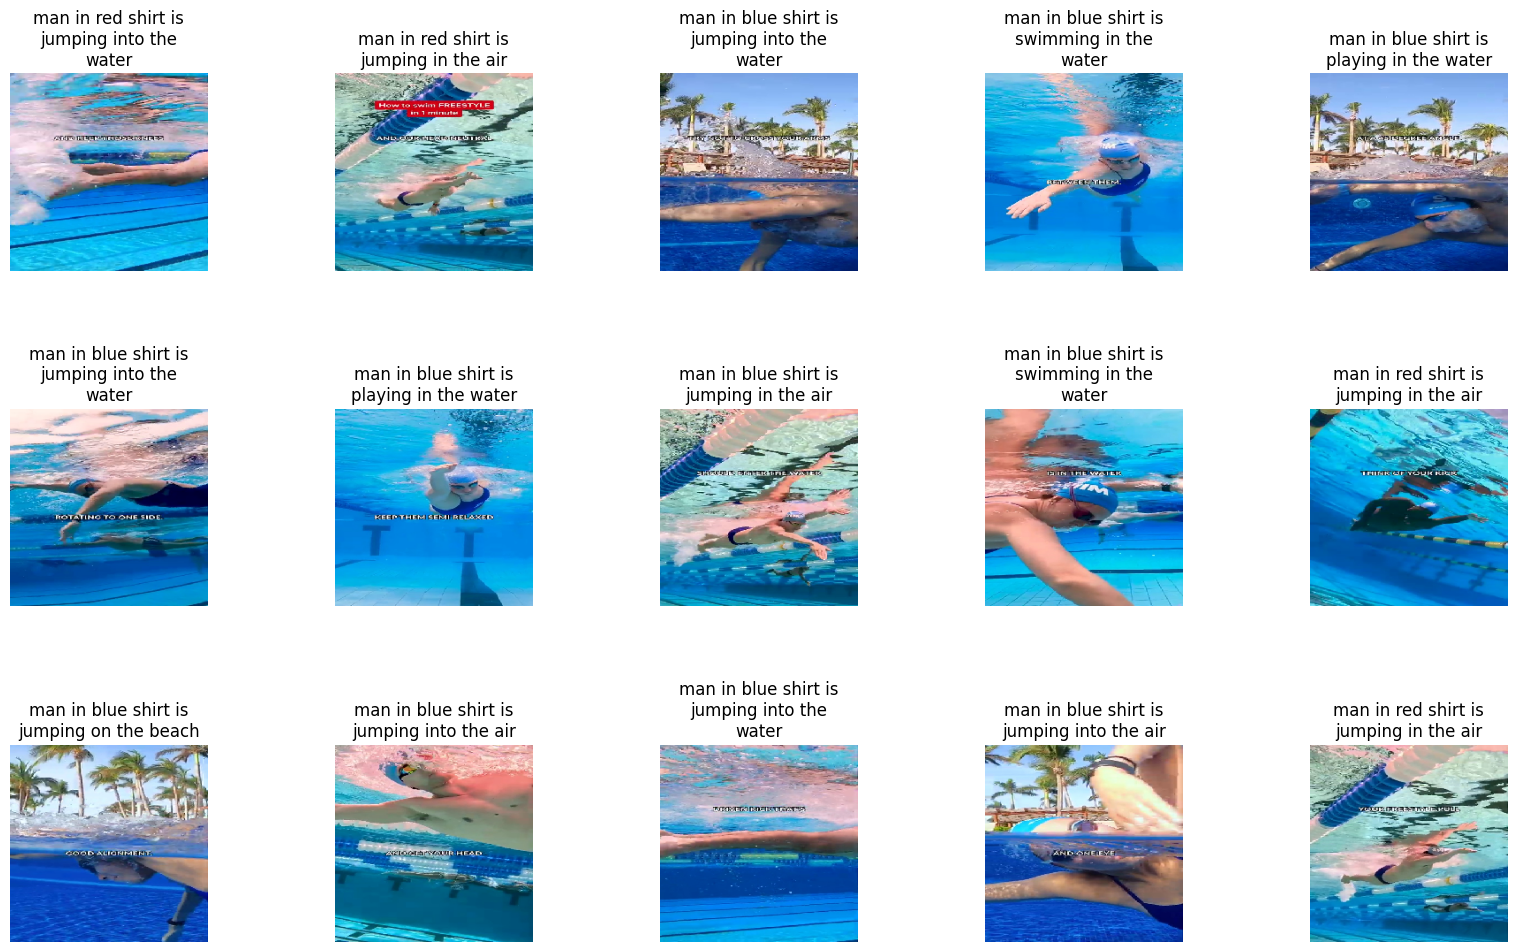

In [ ]:
display_imgs(gen_captions_df,path)

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string


all_captions = ' '.join(gen_captions_df['caption'])
tokens = word_tokenize(all_captions)
stop_words = set(stopwords.words("english"))
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

predicted_hashtags_list =filtered_tokens

all_captions1 = ' '.join(ground_truth[0])
tokens = word_tokenize(all_captions1)
stop_words = set(stopwords.words("english"))
filtered_tokens1 = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
ground_hashtags_list =filtered_tokens1
print(predicted_hashtags_list)
#print(ground_hashtags_list)

['man', 'red', 'shirt', 'jumping', 'water', 'man', 'red', 'shirt', 'jumping', 'air', 'man', 'blue', 'shirt', 'jumping', 'water', 'man', 'blue', 'shirt', 'swimming', 'water', 'man', 'blue', 'shirt', 'playing', 'water', 'man', 'blue', 'shirt', 'jumping', 'water', 'man', 'blue', 'shirt', 'playing', 'water', 'man', 'blue', 'shirt', 'jumping', 'air', 'man', 'blue', 'shirt', 'swimming', 'water', 'man', 'red', 'shirt', 'jumping', 'air', 'man', 'blue', 'shirt', 'jumping', 'beach', 'man', 'blue', 'shirt', 'jumping', 'air', 'man', 'blue', 'shirt', 'jumping', 'water', 'man', 'blue', 'shirt', 'jumping', 'air', 'man', 'red', 'shirt', 'jumping', 'air', 'man', 'blue', 'shirt', 'jumping', 'air', 'man', 'blue', 'shirt', 'jumping', 'water', 'man', 'blue', 'shirt', 'jumping', 'water', 'man', 'blue', 'shirt', 'swimming', 'water', 'man', 'blue', 'shirt', 'jumping', 'water', 'two', 'children', 'jumping', 'air', 'water', 'man', 'blue', 'shirt', 'jumping', 'water', 'man', 'blue', 'shirt', 'jumping', 'water', 

In [ ]:
from nltk.metrics import precision, recall, f_measure

# Example lists of predicted and ground truth tokens
predicted_hashtags = predicted_hashtags_list#['man', 'red', 'shirt', 'riding', 'motorcycle', 'two', 'men', 'playing', 'air', 'man', 'blue', 'shirt', 'sitting', 'floor', 'hands', 'head', 'two', 'people', 'walking', 'beach', 'two', 'men', 'playing', 'soccer', 'man', 'blue', 'shirt', 'playing', 'guitar', 'man', 'blue', 'shirt', 'working', 'roof', 'construction', 'site', 'man', 'jumping', 'side', 'road', 'two', 'people', 'walking', 'street', 'two', 'men', 'sitting', 'floor', 'man', 'blue', 'shirt', 'standing', 'grass', 'man', 'blue', 'shirt', 'standing', 'front', 'wall', 'two', 'soccer', 'players', 'playing', 'soccer', 'group', 'people', 'walking', 'street', 'man', 'blue', 'shirt', 'black', 'hat', 'playing', 'guitar']  # Your predicted tokens
predicted_hashtags = [word for word in predicted_hashtags if len(word) >= 5]

ground_hashtags = ['swimming','swim', 'swimmingpool', 'swimmer', 'pool','summer','water' ,'triathlete' ,'triathlontraining' ,'openwaterswimming' ,'photography','ironman' ,'bikini' ,'swimminglessons']
#['dune', 'buggy', 'racer', 'desert', 'player', 'saving', 'puck', 'gentleman', 'sitting', 'table', 'looking', 'box', 'makerbot', 'industries', 'people', 'camels', 'crossing', 'desert', 'horizon', 'three', 'guys', 'blue', 'gold', 'enjoying', 'game', 'man', 'plays', 'guitar', 'another', 'man', 'swings', 'head', 'holding', 'tight', 'microphone', 'three', 'men', 'compacting', 'soil', 'preparation', 'pour', 'concrete', 'slab', 'person', 'flips', 'bike', 'school', 'kids', 'racing', 'snow', 'child', 'instinct', 'protect', 'used', 'karate', 'class', 'person', 'wearing', 'red', 'shirt', 'cooking', 'grill', 'middle', 'eastern', 'woman', 'weaving', 'cloth', 'loom', 'man', 'number', 'eleven', 'uniform', 'making', 'dive', 'missing', 'ball', 'baseball', 'game', 'man', 'men', 'white', 'jackets', 'number', 'back', 'black', 'pants', 'face', 'away', 'camera', 'raised', 'platform', 'crowd', 'gathers', 'behind', 'man', 'sitting', 'playing', 'tambourine', 'trumpet', 'lap']  # Your ground truth tokens

# Convert lists to sets for easier comparison
predicted_set = set(predicted_hashtags)
print(predicted_set)
ground_set = set(ground_hashtags)

# Calculate precision, recall, and F1 score
precision_score = precision(predicted_set, ground_set)
recall_score = recall(predicted_set, ground_set)
f1_score = f_measure(predicted_set, ground_set)

print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")
print(f"F1 Score: {f1_score:.4f}")


{'children', 'swimming', 'water', 'jumping', 'playing', 'beach', 'shirt'}
Precision: 0.1429
Recall: 0.2857
F1 Score: 0.1905


In [ ]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

# Sample list of words
word_list = predicted_hashtags_list

# Tokenize the words
tokenized_words = word_tokenize(' '.join(word_list))

# Perform part-of-speech tagging
pos_tags = pos_tag(tokenized_words)

# Extract verbs (actions) from the list
action_words = [word for word, pos in pos_tags if pos.startswith('VB')]

#print("Original Word List:", word_list)
action_words = list(set(action_words))
print("Action Words:", action_words)


Action Words: ['blue', 'swimming', 'jumping', 'red', 'playing']


In [ ]:
labels_path = '/kaggle/input/sports-1m-dataset/labels.txt'
sports = pd.read_csv(labels_path)
#print(sports)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Sample list of action words
action_words = ['blue', 'swimming', 'jumping', 'red', 'playing']

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Generate similar words for each action word
similar_words_dict = {}

for word in action_words:
    # Tokenize and get embeddings for the word
    inputs = tokenizer(word, return_tensors="pt")
    outputs = model(**inputs)
    word_vect = outputs.pooler_output.detach().numpy()

    # For demonstration, let's use the original word and four similar words based on the embeddings.
    similar_words = [word]

    # You can replace this logic with your own similarity metric and word selection.
    # Here, we are just repeating the word four times for illustration.
    similar_words.extend([word] * 4)

    similar_words_dict[word] = similar_words

# Print the similar words for each action word
for word, similar_words in similar_words_dict.items():
    print(f"Similar words for '{word}': {', '.join(similar_words)}")


Similar words for 'blue': blue, blue, blue, blue, blue
Similar words for 'swimming': swimming, swimming, swimming, swimming, swimming
Similar words for 'jumping': jumping, jumping, jumping, jumping, jumping
Similar words for 'red': red, red, red, red, red
Similar words for 'playing': playing, playing, playing, playing, playing


In [ ]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    similarity = len(intersection) / len(union)
    return similarity

def filter_similar_words_jaccard(list1, list2, threshold=0.5):
    similar_words = set()
    for word1 in list1:
        for word2 in list2:
            similarity = jaccard_similarity(word1, word2)
            if similarity > threshold:
                similar_words.add(word2)
    return similar_words

# Example usage
list1 = action_words
list2 = sport_list

similar_words_in_list2 = filter_similar_words_jaccard(list1, list2)

print("Words in List 2 that are mostly similar to words in List 1:")
print(similar_words_in_list2)


NameError: name 'sport_list' is not defined

In [ ]:
#!python -m spacy download en_core_web_md

import spacy

# Load pre-trained word embeddings model
nlp = spacy.load("en_core_web_md")
str1 = ' '.join(hashtags)
str2 = ' '.join(word_list)
# Sample sentences

sentence1 = nlp(str1)
sentence2 = nlp(str2)

# Calculate similarity between sentences
similarity = sentence1.similarity(sentence2)
print("Word Embeddings Similarity:", similarity)

In [ ]:

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming you have two dataframes: predicted_df and ground_truth_df
ground_truth_df =ground_truth
predicted_df =gen_captions_df
# Extracting captions from dataframes
predicted_captions =gen_captions_df['comment'].tolist()
ground_truth_captions = ground_truth_df[0].tolist()

# Tokenize and convert the text to tensors for predicted captions
predicted_inputs = tokenizer(predicted_captions, return_tensors="pt", padding=True, truncation=True, max_length=50)
predicted_outputs = model(**predicted_inputs)
predicted_last_hidden_states = predicted_outputs.last_hidden_state
predicted_target_embedding = predicted_last_hidden_states[:, target_token_position, :].detach().numpy()

# Tokenize and convert the text to tensors for ground truth captions
ground_truth_inputs = tokenizer(ground_truth_captions, return_tensors="pt", padding=True, truncation=True, max_length=50)
ground_truth_outputs = model(**ground_truth_inputs)
ground_truth_last_hidden_states = ground_truth_outputs.last_hidden_state
ground_truth_target_embedding = ground_truth_last_hidden_states[:, target_token_position, :].detach().numpy()

# Compute cosine similarity between predicted and ground truth embeddings
similarities = cosine_similarity(predicted_target_embedding, ground_truth_target_embedding)

# Compute mean similarity across all captions
mean_similarity = np.mean(similarities)

print(f"Mean Cosine Similarity: {mean_similarity:.5f}")


In [ ]:
import numpy as np

def mean_reciprocal_rank(similarities):
    ranks = np.argsort(similarities)[::-1]
    reciprocal_ranks = 1 / (1 + ranks)
    mrr = np.mean(reciprocal_ranks)
    return mrr

# Assuming you have two dataframes: predicted_df and ground_truth_df
predicted_captions = predicted_df['comment'].tolist()
ground_truth_captions = ground_truth_df[0].tolist()

# Calculate similarity scores
similarities = []
for pred_caption in predicted_captions:
    pred_inputs = tokenizer(pred_caption, return_tensors="pt", padding=True, truncation=True, max_length=50)
    pred_outputs = model(**pred_inputs)
    pred_last_hidden_states = pred_outputs.last_hidden_state
    pred_target_embedding = pred_last_hidden_states[:, target_token_position, :].detach().numpy()

    caption_similarities = []
    for gt_caption in ground_truth_captions:
        gt_inputs = tokenizer(gt_caption, return_tensors="pt", padding=True, truncation=True, max_length=50)
        gt_outputs = model(**gt_inputs)
        gt_last_hidden_states = gt_outputs.last_hidden_state
        gt_target_embedding = gt_last_hidden_states[:, target_token_position, :].detach().numpy()

        # Compute cosine similarity between predicted and ground truth embeddings
        similarity = cosine_similarity(pred_target_embedding, gt_target_embedding)
        caption_similarities.append(similarity)

    # Choose the highest similarity score for the current predicted caption
    max_similarity = max(caption_similarities)
    similarities.append(max_similarity)

# Calculate Mean Reciprocal Rank (MRR)
mrr = mean_reciprocal_rank(similarities)

print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Assuming you have two lists: reference_captions and predicted_captions
reference_captions = list(ground_truth_df[0])  # List of lists
predicted_captions = list(gen_captions_df['comment'])  # List of strings

# Calculate BLEU score
bleu_score = corpus_bleu([[ref.split()] for ref in reference_captions], [pred.split() for pred in predicted_captions])

print(f"BLEU Score: {bleu_score:.4f}")


In [ ]:
from rouge import Rouge

# Assuming you have two lists: reference_captions and predicted_captions
rereference_captions = list(ground_truth_df[0])  # List of lists
predicted_captions = list(gen_captions_df['comment'])  # List of strings

# Initialize ROUGE scorer
rouge_scorer = Rouge()

# Calculate ROUGE scores
scores = rouge_scorer.get_scores(predicted_captions, reference_captions, avg=True)

print(f"ROUGE-1 Score: {scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2 Score: {scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L Score: {scores['rouge-l']['f']:.4f}")


In [ ]:
from cider import Cider

# A  # List of strings
reference_captions = list(ground_truth_df[0])  # List of lists
predicted_captions = list(gen_captions_df['comment'])
# Initialize CIDEr scorer
cider_scorer = Cider()

# Calculate CIDEr score
cider_score, _ = cider_scorer.compute_score(reference_captions, predicted_captions)

print(f"CIDEr Score: {cider_score:.4f}")


In [ ]:
from pycocoevalcap.cider.cider import Cider

# Example lists of reference captions and predicted captions
reference_captions = [['a', 'man', 'is', 'riding', 'a', 'horse'],
                      ['a', 'woman', 'in', 'a', 'red', 'dress', 'is', 'dancing']]
predicted_captions = ['a', 'man', 'is', 'riding', 'a', 'bike']

# Assuming you have image IDs associated with your captions
image_ids = [0, 1]

# Convert reference captions to the required format
references = {image_id: [{'caption': ' '.join(ref)} for ref in reference_captions] for image_id in image_ids}

# Convert predicted captions to the required format
hypotheses = {image_id: [{'caption': ' '.join(predicted_captions)}] for image_id in image_ids}

# Create a CIDEr scorer
cider_scorer = Cider()

# Compute the CIDEr score
cider_score, _ = cider_scorer.compute_score(references, hypotheses)

print(f"CIDEr Score: {cider_score:.4f}")
